In [19]:
import numpy as np
from numpy import kron, sqrt, pi, arccos, cos, sin, exp
from numpy.linalg import norm
from numpy.linalg import matrix_power, eig
from scipy.linalg import expm
from copy import deepcopy
import functools as ft
from sklearn.linear_model import LinearRegression

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1, 0], [0, 1]])

def spectral_norm(U0):
    return np.linalg.norm(U0, ord=2)

def commutator(A, B):
    return A@B - B@A

def local_interaction(n, dict):
    R_list = [I] * n
    for i in dict:
        R_list[i] = dict[i]
    return ft.reduce(kron, R_list)

def neighbor_heisenberg(n_qubit):
    edges = []
    for i in range(n_qubit-1):
        edges.append((i, i+1))    
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    edges.append((0, n_qubit-1))

    for i, j in edges:
        XX += local_interaction(n_qubit, {i:X, j:X})
        YY += local_interaction(n_qubit, {i:Y, j:Y})
        ZZ += local_interaction(n_qubit, {i:Z, j:Z})
        ZZ += local_interaction(n_qubit, {i:Z, j:I}) * 0.2
    return [XX, YY, ZZ]

def power_law_heisenberg(n_qubit, r, h=0.2):
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128) 
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    for i in range(n_qubit):
        for j in range(i):
            w = 1 / abs(j-i) ** r
            XX += local_interaction(n_qubit, {i:X, j:X}) * w
            YY += local_interaction(n_qubit, {i:Y, j:Y}) * w
            ZZ += local_interaction(n_qubit, {i:Z, j:Z}) * w
    for i in range(n_qubit):
        YY += h * local_interaction(n_qubit, {i:Y})
    return [XX, YY, ZZ]

def sum_commutator(H_list):
    R = 0
    k = len(H_list)
    for i in range(k):
        for j in range(i):
            R += commutator(H_list[j], H_list[i])
    return R

def sum_second_order_commutator_norm(H_list):
    sum = 0
    n = len(H_list)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_3 in range(gamma_1+1, n):
            for gamma_2 in range(gamma_1+1, n):
                R += commutator(H_list[gamma_3], commutator(H_list[gamma_2], H_list[gamma_1])) / 12
        sum += spectral_norm(R)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_2 in range(gamma_1+1, n):
            R += commutator(H_list[gamma_1], commutator(H_list[gamma_1], H_list[gamma_2])) / 24
        sum += spectral_norm(R)
    return sum

def near_diagonal(R, eigenvalues, eps):
    N = R.shape[0]
    # print(N)
    R_copy = deepcopy(R)
    for i in range(N):
        for j in range(N):
            if abs(eigenvalues[i] - eigenvalues[j]) > eps:
                R_copy[i][j] = 0
    return R_copy

H_tmp = []
def trotter_simulation(H_list, n, T, r):
    U1 = np.eye(2 ** n).astype(np.complex128)
    # print(H_list, T, r)
    for H in H_list:
        H_tmp.append(-1.0j * H * T / r)
        U1 = U1 @ expm(-1.0j * H * T / r)
    return matrix_power(U1, r)

def trotter_error(H_list, n_qubit, T, r):
    U_target = expm(-1.0j* sum(H_list) * T)
    U_impl = trotter_simulation(H_list, n_qubit, T, r)
    return spectral_norm(U_impl - U_target)



def Delta_interference(H, R, h, T):
    r = 100
    # T = 1e6
    # for k in range(r):
    #     sum += expm(-1.0j * H * dt * (r-k)) @ (h*R ) @ expm(-1.0j * (H + h * R) * dt * k)
    # bad numerical precision! Now how to implement it: when T is large the difference between e^-iHT and e^-iH
    Delta = expm(-1.0j * H * T) - expm(-1.0j * (H+h*R) * T)
    T0 = 0.1 / spectral_norm(Delta) * T
    Delta = expm(-1.0j * H * T0) - expm(-1.0j * (H+h*R) * T0)
    return Delta / T0

def interference_bound(H_list, n, T, r):
    H = sum(H_list)
    R = -1.0j * sum_commutator(H_list) / 2
    h = T/r
    return spectral_norm(Delta_interference(H, R, h, T)) * T +  sum_second_order_commutator_norm(H_list) * (T/r)**3 * r + spectral_norm(R) * h
# def interference_bound_new(R, H, T, eps):
#     N = R.shape[0]
#     eigenvalues, eigenvectors = eig(H)
#     R_norm = spectral_norm(R)
#     delta_norm = spectral_norm(near_diagonal(R, eigenvalues, eps)) # eps refers to the spectral gap
#     resid_norm = spectral_norm(R-near_diagonal(R, eigenvalues, eps))
#     # print(R_norm, delta_norm, resid_norm)
#     return (resid_norm *  (1 / (eps * T)) + delta_norm) 

# def interference_bound_new2(R, H, T):
#     eigenvalues, eigenvectors = eig(H)
#     near_norm = {}
#     for i in range(-10, 5):        
#         if i==-10:
#             near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i))
#         else:
#             near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))
#     interference_R = 0
#     for i in range(-10, 5):
#         interference_R += near_norm[i] * min(1, 1/(T*(2**i)))
#     return interference_R

def triangle_bound(H_list, n_qubit, T, r):
    sum_norm_commutator = 0
    k = len(H_list)
    for i in range(k):
        cumsum_H = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
        for j in range(i+1, k):
            cumsum_H += H_list[j]
            sum_norm_commutator += spectral_norm(commutator(H_list[i], cumsum_H))
    return 0.5 * T ** 2 * sum_norm_commutator / r

def interference_bound_new3(R, H, dt, eps):
    H_mat, R_mat = H, R
    HR_mat = H_mat + R_mat * dt / (2j) 
    HR_eigvals, HR_eigvecs = np.linalg.eigh(HR_mat)[0], np.linalg.eigh(HR_mat)[1]
    H_eigvals, H_eigvecs = np.linalg.eigh(H_mat)[0], np.linalg.eigh(H_mat)[1]

    # eps = 1e-3
    dim = len(H_eigvals)
    DR =  np.zeros((dim, dim), dtype=complex)
    RR =  np.zeros((dim, dim), dtype=complex)

    B = H_eigvecs.T.conj() @ R_mat @ HR_eigvecs
    for j in range(dim):
        for k in range(dim):
            v, u = H_eigvecs[:, j], HR_eigvecs[:, k]
            # b_jk = v.T.conj() @ R_mat @ u
            # print('b_jk: ', b_jk)
            if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
                DR += B[j,k] * np.outer(v, u.conj())
            else:
                RR += 1/(H_eigvals[j] - HR_eigvals[k]) * B[j,k] * np.outer(v, u.conj())

    print(f'||Delta(R)||={np.linalg.norm(DR, ord=2)}, ||R(R)||={np.linalg.norm(RR, ord=2)}')

    return np.linalg.norm(DR, ord=2), np.linalg.norm(RR, ord=2)

def bipartite_search(error, H_list, n, T, left_r, right_r, eps):
    if right_r < 0:
        right_r = left_r + 1
        while (error(H_list, n, T, right_r) > eps):
            right_r *= 8
    while not (error(H_list, n, T, left_r) <= eps or right_r == left_r + 1):
        print(left_r, right_r)
        mid = (left_r + right_r) // 2
        if (error(H_list, n, T, mid) >= eps):
            left_r = mid
        else:
            right_r = mid
    return left_r

def evaluate(error_list, r):
    eps = 0
    for alpha in error_list:
        eps += error_list[alpha] * (r ** alpha)
    return eps

def bipartite_search_new(error_list, left_r, right_r, eps):
    if right_r < 0:
        right_r = left_r + 1
        while (evaluate(error_list, right_r) > eps):
            right_r *= 8
    while not (evaluate(error_list, left_r) <= eps or right_r == left_r + 1):
        print(left_r, right_r)
        mid = (left_r + right_r) // 2
        if (evaluate(error_list, mid) >= eps):
            left_r = mid
        else:
            right_r = mid
    return left_r

def log_linear_regression(dict_r):
    # Sample dataset
    X = np.array(list(dict_r.keys()))
    X = np.log(X)
    X = X.reshape(-1,1)
    y = np.array(list(dict_r.values()))
    y = np.log(y)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, y)

    # Output the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    print("Coefficients:", coefficients)
    print("Intercept:", intercept)
    return coefficients, intercept

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt

color_cycle = ["#8491B4FF", "#00A087FF", "#E64B35FF", "#3C5488FF", "#F39B7FFF", "#7E6148FF", "#4DBBD5FF", "#DC0000FF",  "#91D1C2FF", "#B09C85FF", "#923a3a", "#70699e"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', grid=True, edgecolor='k', prop_cycle=colors)
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.dpi'] = 100

SMALL_SIZE = 12
MEDIUM_SIZE = 14  #default 10
LARGE_SIZE = 16

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title


## A+B

In [21]:
n = 8
H_list = neighbor_heisenberg(n)
H = H_list[0] + H_list[2]
R = commutator(H_list[0], H_list[2])
R2 = sum_second_order_commutator_norm([H_list[0], H_list[2]])
print(R2)
print(1/24 * np.linalg.norm(commutator(H_list[0], commutator(H_list[0], H_list[2])), ord=2) + 1/12 * np.linalg.norm(commutator(H_list[2], commutator(H_list[0], H_list[2])), ord=2))
print(np.linalg.norm(H_list[0], ord=2), np.linalg.norm(H_list[2], ord=2))

12.560148619736992
12.560148619736989
8.000000000000002 9.6


30.71935359984006
||Delta(R)||=0.016321015463787593, ||R(R)||=4.627685504844205
r=100, 2, 2
||Delta(R)||=0.04001449457885386, ||R(R)||=7.528502353790513
r=162, 2, 2
||Delta(R)||=0.09472480062588966, ||R(R)||=10.958837405236473
r=264, 2, 2
||Delta(R)||=0.16597684909474722, ||R(R)||=17.41816574198483
r=428, 2, 2
||Delta(R)||=0.27395063069051256, ||R(R)||=28.282786380504717
r=695, 2, 2
||Delta(R)||=0.3357304787796908, ||R(R)||=45.23270529098336
r=1129, 1.1275061013320402, 2
||Delta(R)||=0.35848673776858786, ||R(R)||=3.8821562060841437
r=1833, 0.4906011789401296, 1.8435977820635696
||Delta(R)||=0.220963095583031, ||R(R)||=3.880130480372023
r=2976, 0.22483468831611375, 0.7495686213358833
||Delta(R)||=0.1360994422247465, ||R(R)||=3.879380057362473
r=4833, 0.10910084830474079, 0.3150646487096411
||Delta(R)||=0.08382235086268133, ||R(R)||=3.8790981580055193
r=7848, 0.05606110753442532, 0.13847502974307047
||Delta(R)||=0.0516255245073237, ||R(R)||=3.878991631793479
r=12743, 0.03030695154367024,

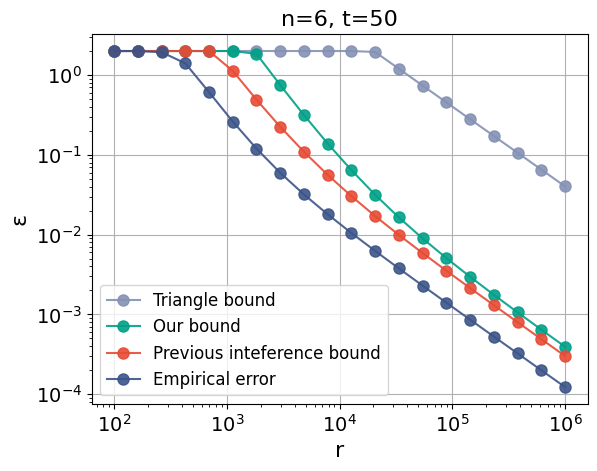

In [26]:
fig, ax = plt.subplots()
n = 6
H_list = neighbor_heisenberg(n)
H = H_list[0] + H_list[2]
R = commutator(H_list[0], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)
print(R2)
A2 = 1/24 * np.linalg.norm(commutator(H_list[0], commutator(H_list[0], H_list[2])), ord=2) + 1/12 * np.linalg.norm(commutator(H_list[2], commutator(H_list[0], H_list[2])), ord=2)

T = 50
eps = 0.01

emepricial_error = {}
interference_bound = {}
our_interference_bound = {}
triangle_bound = {}

r_num = 20
logspace_seq = np.logspace(2, 6, num = r_num)
# logspace_seq = np.logspace(4, 9, num = 10)

for i in range(r_num):
    r = round(logspace_seq[i])
    # emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    emepricial_error[r] = trotter_error([H_list[0], H_list[2]], n, T, r)
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
    DR, RR = interference_bound_new3(R, H, T/r, eps)
    our_interference_bound[r] = min(triangle_bound[r],  DR * T**2/r + 2 * RR * T/r + R2 * T**3/(r*r))
    interference_bound[r] = min(triangle_bound[r], min(spectral_norm(H_list[0]), spectral_norm(H_list[2])) * T/r + A2 * T**3/r**2 )
    print(f'r={r}, {interference_bound[r]}, {our_interference_bound[r]}')
    # interference_bound[r] = min(2, interference_bound_new2(R, H, T) * T*T/r + R2 * T*T*T/(r*r))
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n={n}, t={T}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = f"Interference bound, ε={eps}"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
y3_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
    y3_list.append(our_interference_bound[r])
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.plot(x_list, y3_list, marker="o", label = 'Our bound')
ax.plot(x_list, y1_list, marker="o", label = 'Previous inteference bound')
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")

## Debug

## A+B+C

||Delta(R)||=0.9499987180569722, ||R(R)||=11.905565837051636
||Delta(R)||=2.109547173796547, ||R(R)||=24.408362264834597
||Delta(R)||=4.576776980729445, ||R(R)||=46.8829768461395
||Delta(R)||=8.092158511388133, ||R(R)||=12.151310976170372
||Delta(R)||=7.845929593334383, ||R(R)||=11.79469848346675
||Delta(R)||=7.729350918679448, ||R(R)||=11.811016566779974
||Delta(R)||=7.674797242567208, ||R(R)||=11.793748575155455
||Delta(R)||=7.649369387316574, ||R(R)||=11.790028661346785
||Delta(R)||=7.63754421113429, ||R(R)||=11.789227243669806
||Delta(R)||=7.632050898087496, ||R(R)||=11.789054594371052
{100: 1.99755565995175, 215: 1.9988326836756838, 464: 1.9984307840627042, 1000: 1.4072254541176745, 2154: 0.7016741224737156, 4642: 0.3292955048967609, 10000: 0.1529850559471887, 21544: 0.07097169334857076, 46416: 0.0329266402170868, 100000: 0.015279372082312725} {100: 2, 215: 2, 464: 2, 1000: 2, 2154: 2, 4642: 2, 10000: 1.1833226568971382, 21544: 0.5492585670707103, 46416: 0.25493852483995566, 10000

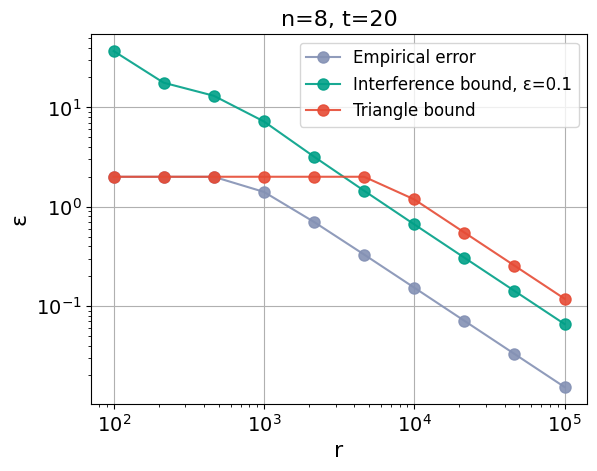

In [35]:
fig, ax = plt.subplots()
n = 8
alpha = 4
H_list = power_law_heisenberg(n, alpha)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 0.1

emepricial_error = {}
interference_bound = {}
triangle_bound = {}

r_num = 10
logspace_seq = np.logspace(2, 5, num = r_num)
# logspace_seq = np.logspace(4, 9, num = 10)

for i in range(r_num):
    r = round(logspace_seq[i])
    # emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    emepricial_error[r] = trotter_error(H_list, n, T, r)
    DR, RR = interference_bound_new3(R, H, T/r, eps)
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
    interference_bound[r] = DR * T**2/r * (1 + T * eps/2) + 2 * RR * T/r + R2 * T**3/(r*r)
    # interference_bound[r] = min(2, interference_bound_new2(R, H, T) * T*T/r + R2 * T*T*T/(r*r))
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n={n}, t={T}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = f"Interference bound, ε={eps}"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.plot(x_list, y1_list, marker="o", label = y1_title)
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")

In [170]:
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 1
r = 1000000
h = T*T/r
print(h)
eigenvalues, eigenvectors = eig(H)

near_norm = {}
for i in range(-20, 11):
    near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))

interference_R = 0
for i in range(-20, 11):
    interference_R += near_norm[i] * min(1, 1/(2*pi*T*(2**i)))

print(near_norm)
print(interference_R)

print(spectral_norm(expm(-1.0j * H* T - h * R) - expm(-1.0j * H * T))) #emperical error
# print(spectral_norm(near_diagonal(R, eigenvalues, eps)) * h + (spectral_norm(R) - spectral_norm(near_diagonal(R, eigenvalues, eps))) * h / (T * eps)) #interference bound
print(interference_R * h)
print(spectral_norm(R) * h)

0.0004
{-20: 0.0, -19: 0.0, -18: 0.0, -17: 0.0, -16: 0.0, -15: 0.0, -14: 0.0, -13: 0.0, -12: 0.0, -11: 0.0, -10: 0.0, -9: 0.0, -8: 0.0, -7: 8.8, -6: 0.0, -5: 0.0, -4: 0.8664367788756575, -3: 4.419375868779138, -2: 3.1894535369173145, -1: 1.3352687652011639, 0: 2.774002483808644, 1: 2.983441328929718, 2: 4.450334310342825, 3: 5.286452365077555, 4: 3.4405946439588178, 5: 0.5456442739406597, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
9.3643439230543
0.0004055389354541708
0.00374573756922172
0.015236401742332598


In [1002]:
n = 4
t, r = n, 100
dt = t / r

H_list = neighbor_heisenberg(n)
R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
# R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
H = sum(H_list)
HR = H + R * dt / (2j)

HR_eigvals, HR_eigvecs = np.linalg.eigh(HR)[0], np.linalg.eigh(HR)[1]
H_eigvals, H_eigvecs = np.linalg.eigh(H)[0], np.linalg.eigh(H)[1]
print('test correctness of eigen: ', norm(np.dot(H, H_eigvecs[:, 2]) - H_eigvals[2] * H_eigvecs[:, 2], ord=1))
print('HR_eigvals: ', HR_eigvals)
print('H_eigvals: ', H_eigvals)
# print('|HR_eigvals-H_eigvals|: ', norm(HR_eigvals - H_eigvals, ord=1))
# print(norm(HR_eigvals-H_eigvals, ord=2))

eps = 1e-3
dim = 2**n
DR =  np.zeros((dim, dim), dtype=complex)
RR =  np.zeros((dim, dim), dtype=complex)

for j in range(dim):
    for k in range(dim):
        v, u = HR_eigvecs[:, j], HR_eigvecs[:, k]
        b_jk = v.T.conj() @ R @ u
        # print('b_jk: ', b_jk)
        if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
            print(H_eigvals[j], HR_eigvals[k])
            DR += b_jk * v @ u.T.conj()
        else:
            print(H_eigvals[j]-HR_eigvals[k])
            RR += 1/(H_eigvals[j] - HR_eigvals[k]) * b_jk * v @ u.T.conj()

# print(DR, RR)
print(f"||Delta(R)||={norm(DR, ord=2)}, ||R(R)||={norm(RR, ord=2)}")

test correctness of eigen:  2.49479500149234e-15
HR_eigvals:  [-8.03003650e+00 -4.42014790e+00 -3.98028402e+00 -3.60999827e+00
 -5.99262014e-01 -2.87785636e-01 -2.00763647e-01  3.24250366e-16
  2.00763647e-01  2.76789416e-01  5.99262014e-01  3.06544730e+00
  3.60999827e+00  3.94479025e+00  4.42014790e+00  5.01107920e+00]
H_eigvals:  [-8.02981083e+00 -4.41500915e+00 -3.98024805e+00 -3.61500915e+00
 -5.99252348e-01 -2.87318241e-01 -2.00747652e-01 -1.07836911e-16
  2.00747652e-01  2.77394009e-01  5.99252348e-01  3.20000000e+00
  3.61500915e+00  4.01998311e+00  4.41500915e+00  4.80000000e+00]
-8.029810834988577 -8.030036500526638
-3.609662934489827
-4.04952681330796
-4.419812561490382
-7.430548821164219
-7.742025198696156
-7.829047188270079
-8.029810834988577
-8.230574481707077
-8.306600250674283
-8.629072848812935
-11.095258132884618
-11.639809108486777
-11.974601083366316
-12.449958735487327
-13.040890031528763
3.615027347122197
0.005138747094309615
-0.43472513172382365
-0.80501087990624

## Bipartite search

In [28]:
trotter_error_r = {}
triangle_r = {}
approx_interference_r = {}
N = 10
h = 0.1
r_min = 100
r_max = 200000000
eps = 1e-2
eps_inter = 1e-4
alpha = 10
interactions = [[Y, X], [X, Z], [X, X]]
for n in range(4, N):
    T = n * 1
    H_list = power_law_heisenberg(n, alpha, h=h)
    # H0_list = power_law_heisenberg(n, 10000）
    H = sum(H_list)
    R = sum_commutator(H_list)
    R2 = sum_second_order_commutator_norm(H_list)
    trotter_error_r[n] = bipartite_search(trotter_error, H_list, n, T, r_min, r_max, eps)
    triangle_bound_list = {-1:T*T*spectral_norm(R)/2}
    triangle_r[n] = bipartite_search_new(triangle_bound_list, r_min, r_max, eps)
    DR, RR = interference_bound_new3(R/2, H, T/r_max, eps_inter)
    interference_bound_coeff_list = {-1: ((1+T*eps_inter)*DR*T*T + RR * 2 * T), -2:R2*T*T*T}
    approx_interference_r[n] = bipartite_search_new(interference_bound_coeff_list, r_min, r_max, eps)

print(trotter_error_r)
print(triangle_r)
print(approx_interference_r)
data = {"Trotter": trotter_error_r, "Triangle": triangle_r, "Interference": approx_interference_r}
data_dir, fig_dir = "data", "figs"
prefix = "power_law"
n_max = N-1
np.save(f'{data_dir}/{prefix}_data_max={n_max}_alpha={alpha}_h={h}_2norm.npy', data)


100 200000000
100 100000050
100 50000075
100 25000087
100 12500093
100 6250096
100 3125098
100 1562599
100 781349
100 390724
100 195412
100 97756
100 48928
100 24514
100 12307
100 6203
3151 6203
3151 4677
3151 3914
3151 3532
3341 3532
3436 3532
3484 3532
3484 3508
3484 3496
3484 3490
3484 3487
3485 3487
100 200000000
100 100000050
100 50000075
100 25000087
100 12500093
100 6250096
100 3125098
100 1562599
100 781349
100 390724
100 195412
100 97756
100 48928
100 24514
100 12307
6203 12307
9255 12307
10781 12307
10781 11544
11162 11544
11162 11353
11162 11257
11209 11257
11233 11257
11233 11245
11233 11239
11236 11239
11237 11239
||Delta(R)||=1.6542535044661452e-07, ||R(R)||=6.12789729893582
100 200000000
100 100000050
100 50000075
100 25000087
100 12500093
100 6250096
100 3125098
100 1562599
100 781349
100 390724
100 195412
100 97756
100 48928
100 24514
100 12307
100 6203
3151 6203
4677 6203
4677 5440
4677 5058
4867 5058
4867 4962
4914 4962
4914 4938
4914 4926
4914 4920
4917 4920
4918 49

Coefficients: [2.48355507]
Intercept: 4.8924662179296465
Coefficients: [-5.4616315]
Intercept: 24.713878278481673
Coefficients: [3.18720606]
Intercept: 4.875511663287212
Coefficients: [2.08927657]
Intercept: 5.241240680057507
[-1.48903821] [3.18720606] [2.08927657]


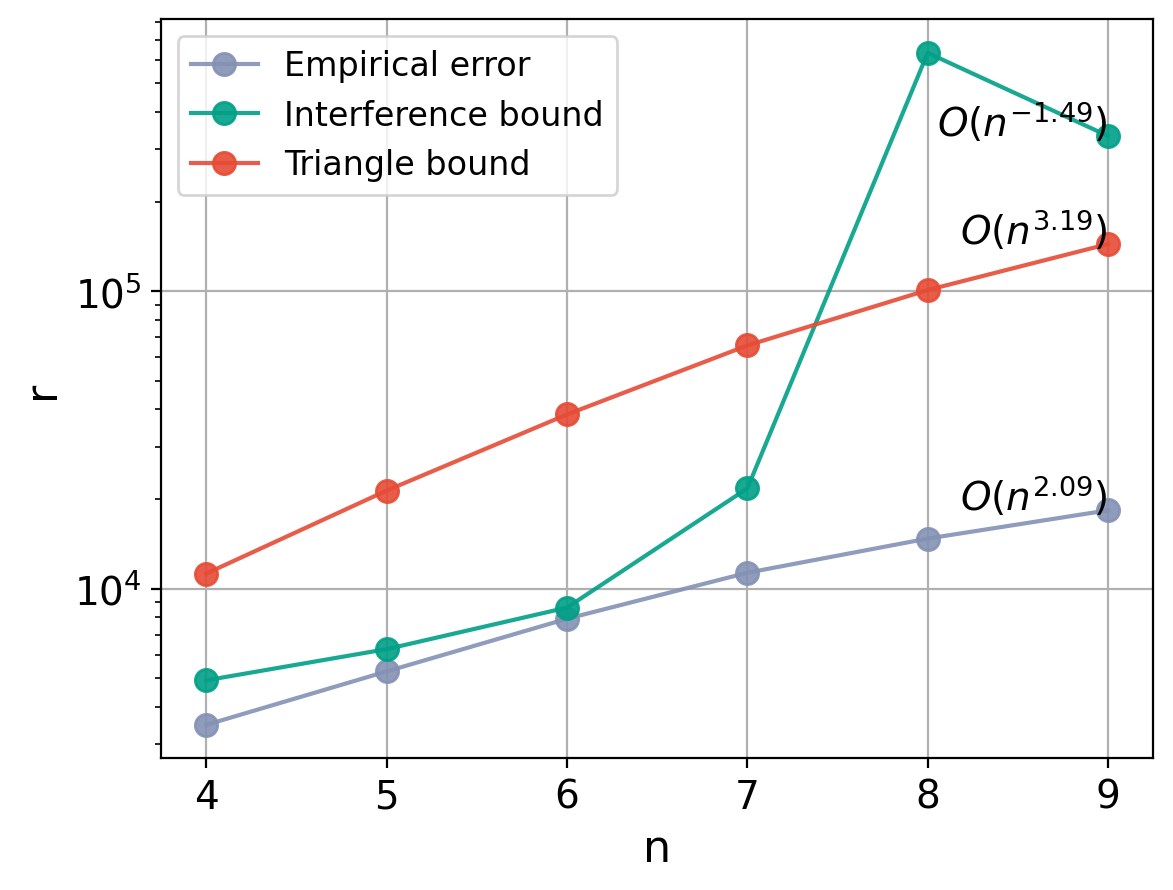

In [29]:
data_dir = "data"
prefix = "power_law"
n_max = N-1
alpha = alpha
data1 = np.load(f'{data_dir}/{prefix}_data_max={n_max}_alpha={alpha}_h={h}_2norm.npy', allow_pickle=True).item()
approx_interference_r = data1["Interference"]
triangle_r = data1["Triangle"]
trotter_error_r = data1["Trotter"]

import matplotlib as mpl
import matplotlib.pyplot as plt

color_cycle = ["#8491B4FF", "#00A087FF", "#E64B35FF", "#3C5488FF", "#F39B7FFF", "#7E6148FF", "#4DBBD5FF", "#DC0000FF",  "#91D1C2FF", "#B09C85FF", "#923a3a", "#70699e"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', grid=True, edgecolor='k', prop_cycle=colors)
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.dpi'] = 100

SMALL_SIZE = 12
MEDIUM_SIZE = 14  #default 10
LARGE_SIZE = 16

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

# plt.cla()
fig, ax = plt.subplots()
x_list = []
y_list = []
y1_list = []
y2_list = []
title = ""
y_title = "Empirical error"
y1_title = "Interference bound"
y2_title = "Triangle bound"
x_label = "n"
y_label = "r"

threshold = 7.5
small_approx_c,_ = log_linear_regression({k:v for k, v in approx_interference_r.items() if k < threshold})
large_approx_c,_ = log_linear_regression({k:v for k, v in approx_interference_r.items() if k > threshold})
approx_c = (small_approx_c+large_approx_c)/2
triangle_c,_ = log_linear_regression(triangle_r)
trotter_c,_ = log_linear_regression(trotter_error_r)
print(approx_c, triangle_c, trotter_c)


for n in trotter_error_r:
    y_list.append(trotter_error_r[n])
    x_list.append(n)
    y1_list.append(approx_interference_r[n])
    y2_list.append(triangle_r[n])
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.plot(x_list, y1_list, marker="o", label = y1_title)
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
# ax.set_ylim(0, 1.4e6)

# s_triangle = rf"O(n^{{{triangle_c}}})"

ax.text(x_list[-1], y_list[-1], rf"$O(n^{{{trotter_c[0]:.2f}}})$", ha='right')
ax.text(x_list[-1], y1_list[-1], rf"$O(n^{{{approx_c[0]:.2f}}})$", ha='right')
ax.text(x_list[-1], y2_list[-1], rf"$O(n^{{{triangle_c[0]:.2f}}})$", ha='right')

ax.set_yscale("log")
# ax.set_xscale("log")
ax.legend(loc = "best")
# plt.show()
fig.savefig(f"{fig_dir}/power_law_α={alpha}_nmax={n_max}_triangle_r.pdf")

## Debug

## Eigen decomposition

In [13]:
# test = [[1,0], [0,-1]]
v1, v2 = np.array([1,0]), np.array([0,1j])
print(np.outer(v1, v2))
print(np.outer(v1, v2.T))
print(np.outer(v1, v2.conj()))
print(v1 @ v2.T.conj())
print(v1.T.conj() @ v2)

[[0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j]]
[[0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j]]
[[0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j]]
0j
0j


In [3]:
data = {1:1, 2:4, 3:5}
np.save(f'data/test.npy', data)


In [7]:
data1 = np.load(f'data/power_law_data_max=6_alpha=4_2norm.npy', allow_pickle=True).item()
print(data1)

{'Trotter': {4: 443686, 5: 643430, 6: 937328}, 'Triangle': {4: 1058693, 5: 1978019, 6: 3474663}, 'Interference': {4: 453482, 5: 662742, 6: 976674}}
